In [2]:
#-------------------------Imports---------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import random

from pycbc.waveform import get_td_waveform
from pycbc import types, fft, waveform

from scipy.stats import uniform
from scipy import interpolate
from scipy.integrate import quad
from scipy import constants
from scipy.optimize import curve_fit

import os
from astropy.cosmology import Planck15
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy import constants as astro_const

from multiprocessing import Pool
from multiprocessing import Process
import time
from tqdm import tqdm

###########################
# CONSTANTS
###########################
H0GLOB= 67#67.9 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoglob = Planck18
cosmo15 = Planck15
cosmoeuclid = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value
h=H0/100
#geometrization of masses
Msun=(1.98892)*(10**30)
solarmass_to_m=(constants.G*Msun)/((constants.c)**2)#G/c^2
Mpc_to_m=3.08567758128*(10**22) #this will be used later

#from lum distance to z
zz=np.linspace(0,10,10000)
distinterpol=cosmoglob.comoving_distance(zz).value*(1+zz)
z_of_dl=interpolate.interp1d(distinterpol,zz)
distinterpol_comov=cosmoglob.comoving_distance(zz).value
z_of_dc=interpolate.interp1d(distinterpol_comov,zz)

In [3]:
def phi_from_cart(x,y):
    if(x>0):
        phi=np.arctan(y/x)
    if ((x<0) and (y>=0)):
        phi=np.arctan(y/x)+np.pi
    if ((x<0) and (y<0)):
        phi=np.arctan(y/x)-np.pi
    return phi
def theta_from_cart(x,y,z):
    den=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/den)
    return theta

# ET Functions & Noise

Global variables needed, they are all array. Use always those names: 
**m1,m2,inclin,psi,phi,cos_theta,com_distance,zz**

In [7]:
#-----------------Einstein Telescope Stuff------------------------------
#Antennas behave like an L-shaped interferometer but with sin(60°)
#There are 3 antennas, phi rotates each time
#The SNR is the square root of the sum of each SNR^2 

def ET_antenna_one_plus(cos_theta,phi,psi):
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_one_cross(cos_theta,phi,psi):
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
def ET_antenna_two_plus(cos_theta,phi,psi):
    phi=phi+(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_two_cross(cos_theta,phi,psi):
    phi=phi+(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
def ET_antenna_three_plus(cos_theta,phi,psi):
    phi=phi+(4*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.cos(2*psi)-B*np.sin(2*psi))
    return ret
def ET_antenna_three_cross(cos_theta,phi,psi):
    phi=phi+(4*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.cos(2*phi))
    B=2*(cos_theta)*(np.sin(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
#----function that perform the SNR-----------------
#---use this function in a loop, you must provide the angles for each ds
#read it from the EVA (catalogues) series.
def ET_SNR_Evaluation(ds_theta,ds_phi,ds_psi,hp,hc):
    temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
    temp_cross=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hc))[0]
    first_prefactor=(ET_antenna_one_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_one_cross(ds_theta,ds_phi,ds_psi))**2
    firstSNR=(temp_plus+temp_cross)*first_prefactor*4
    second_prefactor=(ET_antenna_two_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_two_cross(ds_theta,ds_phi,ds_psi))**2
    secondSNR=(temp_plus+temp_cross)*second_prefactor*4
    third_prefactor=(ET_antenna_three_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_three_cross(ds_theta,ds_phi,ds_psi))**2
    thirdSNR=(temp_plus+temp_cross)*third_prefactor*4
    totSNR=np.sqrt(firstSNR+secondSNR+thirdSNR)
    return totSNR



In [8]:
def signal_noise_toint(f,signal):
    #numerator=((constant/dist)*(mass**(5/6))*(((1+cos**2)/2)**2)*f**(-7/6))**2
    numerator=(signal(f)**2)
    #numerator= (np.real(signal(f))**2)+(np.imag(signal(f))**2)
    denom=(ET_sn(f)**2)
    return (numerator/denom)

In [10]:
#This is for ET only
#find a way to not use global variable?
def Multi_SNR(i):
    lum_distance=(1+zz[i])*com_distance[i]
    fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1[i]+m2[i])*astro_const.M_sun.value)
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
    #FDhp,FDhc = waveform.get_fd_waveform(approximant="IMRPhenomD",
    #                           mass1=m1[i], mass2=m2[i],inclination=inclin[i],
    #                           distance=lum_distance[i],
    #                           spin1z=0,spin2z=0,  
    #                           delta_f=1.0/500,f_lower=0.5,f_final=0)
    FDhp,FDhc = waveform.get_fd_waveform(
                                         approximant="IMRPhenomD",
                                         mass1=m1[i], 
                                         mass2=m2[i],
                                         inclination=inclin[i],
                                         spin1z=0,
                                         spin2z=0,  
                                         distance=lum_distance,
                                         delta_f=df,
                                         f_lower=0.5,f_final=0
                                        )
    freq=np.array(FDhp.sample_frequencies)
    FDwfp = np.array(FDhp.data)[freq>=ET_min_freq]
    FDwfc = np.array(FDhc.data)[freq>=ET_min_freq]
    freq=freq[freq>=ET_min_freq]
    hp_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfp*(1+zz[i])**2),fill_value="extrapolate")
    hc_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfc*(1+zz[i])**2),fill_value="extrapolate")
    #hp_interpol=interpolate.interp1d(freq,abs(FDwfp**2),fill_value="extrapolate")
    #hc_interpol=interpolate.interp1d(freq,abs(FDwfc**2),fill_value="extrapolate")
    temp=ET_SNR_Evaluation(cos_theta[i],phi[i],psi[i],hp_interpol,hc_interpol)
    return temp

def Multi_SNR_plus(i):
    lum_distance=(1+zz[i])*com_distance[i]
    fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1[i]+m2[i])*astro_const.M_sun.value)
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
    FDhp,FDhc = waveform.get_fd_waveform(
                                         approximant="IMRPhenomD",
                                         mass1=m1[i], 
                                         mass2=m2[i],
                                         inclination=inclin[i],
                                         spin1z=0,
                                         spin2z=0,  
                                         distance=lum_distance,
                                         delta_f=df,
                                         f_lower=0.5,f_final=0
                                        )
    freq=np.array(FDhp.sample_frequencies)
    FDwfp = np.array(FDhp.data)[freq>=ET_min_freq]
    FDwfc = np.array(FDhc.data)[freq>=ET_min_freq]
    freq=freq[freq>=ET_min_freq]
    falsecross=np.zeros(len(freq))
    falsecross=falsecross.astype(int)
    hp_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfp*(1+zz[i])**2),fill_value="extrapolate")
    hc_interpol=interpolate.interp1d(freq/(1+zz[i]),falsecross,fill_value="extrapolate")
    temp=ET_SNR_Evaluation(cos_theta[i],phi[i],psi[i],hp_interpol,hc_interpol)
    return temp


In [11]:
#---------------Einstein Telescope Noise-----------------
ET_freq=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=0)
ET_noise=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=3)#This is the amplitude so must be squared
ET_sn=interpolate.interp1d(ET_freq,ET_noise,kind='cubic',fill_value="extrapolate")
ET_min_freq=ET_freq.min()
ET_max_freq=ET_freq.max()
print('Freq_min={}, Freq_max={}'.format(ET_min_freq,ET_max_freq))

Freq_min=1.0, Freq_max=10000.0


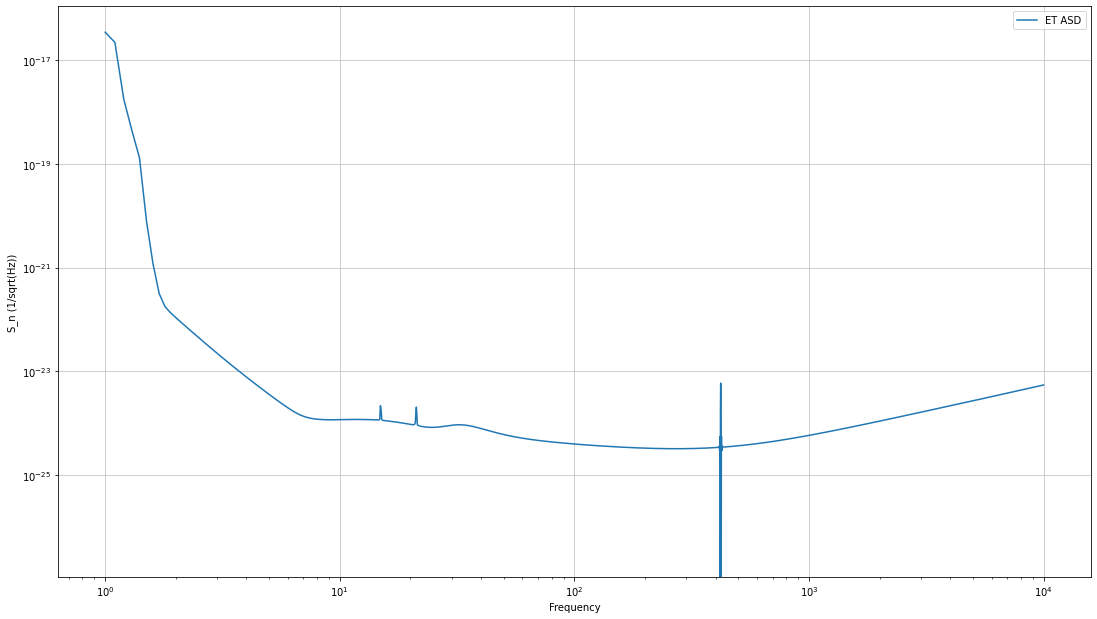

In [12]:
#######--Some Miscellaneous plots--##########
freq_for_plot_ET=np.linspace(ET_freq.min(),ET_freq.max(),100000)
plt.rcParams.update({'font.size': 25})
fig,ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Frequency')
ax.set_ylabel('S_n (1/sqrt(Hz))')
#ax.plot(freq_for_plot_ET,hp_interpol(freq_for_plot_ET),label='H+')
#ax.plot(freq_for_plot_ET,hc_interpol(freq_for_plot_ET),label='HX')
ax.plot(freq_for_plot_ET,ET_sn(freq_for_plot_ET),label='ET ASD')

plt.yscale('log')
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()

# aLIGO Network 
Global variables needed, they are all array. Use always those names: 
**m1,m2,inclin,psi,phi,theta for network (cos_theta),com_distance,zz**

In [14]:
#network antenna from: Networks of gravitational wave detectors and three figures of merit
#we have to set a global reference frame and evaluate f_+ and f_x for each detector
#having care to rotate each S.o.R.
def A_factor(xi,beta,lamb,theta,phi):
    a1=(1/16)*np.cos(2*xi)*(3-np.cos(2*beta))*(3-np.cos(2*theta))*np.cos(2*(phi+lamb))
    a2=0.25*np.cos(2*xi)*np.sin(beta)*(3-np.cos(2*theta))*np.sin(2*(phi+lamb))
    a3=0.25*np.sin(2*xi)*np.sin(2*beta)*np.sin(2*theta)*np.cos(phi+lamb)
    a4=0.5*np.cos(2*xi)*np.cos(beta)*np.sin(2*theta)*np.sin(phi+lamb)
    a5=(3/4)*np.sin(2*xi)*(np.cos(beta)**2)*(np.sin(theta)**2)
    ret=a1+a2+a3+a4+a5
    return ret
def B_factor(xi,beta,lamb,theta,phi):
    b1=np.cos(2*xi)*np.sin(beta)*np.cos(theta)*np.cos(2*(phi+lamb))
    b2=0.25*np.sin(2*xi)*(3-np.cos(2*beta))*np.cos(theta)*np.sin(2*(phi+lamb))
    b3=np.cos(2*xi)*np.cos(beta)*np.sin(theta)*np.cos(phi+lamb)
    b4=0.5*np.sin(2*xi)*np.sin(2*beta)*np.sin(theta)*np.sin(phi+lamb)
    ret=b1-b2+b3-b4
    return ret
def antenna_pattern(xi,beta,lamb,theta,phi,psi):
    fplus=A_factor(xi,beta,lamb,theta,phi)*np.cos(2*psi)+B_factor(xi,beta,lamb,theta,phi)*np.sin(2*psi)
    fcross=B_factor(xi,beta,lamb,theta,phi)*np.cos(2*psi)-A_factor(xi,beta,lamb,theta,phi)*np.sin(2*psi)
    fplus_squared=fplus**2
    fcross_squared=fcross**2
    ret=fplus_squared+fcross_squared
    return ret
def rad_from_deg(angle):
    if angle<0:
        convert=360+angle #angle is negative
    else:
        convert=angle
    ret=convert*np.pi/180
    return ret
#gamma, lambda, L of other paper
Ligo_H=np.array([rad_from_deg(171),rad_from_deg(46.45),rad_from_deg(-119.41)])
Ligo_L=np.array([rad_from_deg(243),rad_from_deg(30.56),rad_from_deg(-90.77)])
Virgo=np.array([rad_from_deg(116.5),rad_from_deg(43.63),rad_from_deg(10.5)])
LCGT=np.array([rad_from_deg(70),rad_from_deg(36.25),rad_from_deg(137.18)])


In [15]:
def signal_noise_toint_network(f,signal):
    #numerator=((constant/dist)*(mass**(5/6))*(((1+cos**2)/2)**2)*f**(-7/6))**2
    numerator=(signal(f)**2)
    #numerator= (np.real(signal(f))**2)+(np.imag(signal(f))**2)
    denom=(Aligo_sn(f)**2)
    return (numerator/denom)
def network_angular_response(i):
    #m1,m2,inclin,psi,phi,cos_theta,com_distance,zz
    lum_distance=(1+zz[i])*com_distance[i]
    fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1[i]+m2[i])*astro_const.M_sun.value)
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
    FDhp,FDhc = waveform.get_fd_waveform(
                                         approximant="IMRPhenomD",
                                         mass1=m1[i], 
                                         mass2=m2[i],
                                         inclination=inclin[i],
                                         spin1z=0,
                                         spin2z=0,  
                                         distance=lum_distance,
                                         delta_f=df,
                                         f_lower=0.5,f_final=0
                                        )
    freq=np.array(FDhp.sample_frequencies)
    FDwfp = np.array(FDhp.data)[freq>=Aligo_min_freq]
    FDwfc = np.array(FDhc.data)[freq>=Aligo_min_freq]
    freq=freq[freq>=Aligo_min_freq]
    falsecross=np.zeros(len(freq))
    falsecross=falsecross.astype(int)
    hp_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfp*(1+zz[i])**2),fill_value="extrapolate")
    hc_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfc*(1+zz[i])**2),fill_value="extrapolate")
    ###--------Now compute the SNR in each detector of the network--------------###
    #-----we are using the same noise for all the detectors. This can be improven
    temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
    temp_cross=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hc_interpol))[0]
    
    hanford_prefactor=antenna_pattern(Ligo_H[0],Ligo_H[1],Ligo_H[2],theta[i],phi[i],psi[i])
    SNR_quad_hanford=(temp_plus+temp_cross)*hanford_prefactor*4
    
    livingstone_prefactor=antenna_pattern(Ligo_L[0],Ligo_L[1],Ligo_L[2],theta[i],phi[i],psi[i])
    SNR_quad_livingstone=(temp_plus+temp_cross)*livingstone_prefactor*4
    
    virgo_prefactor=antenna_pattern(Virgo[0],Virgo[1],Virgo[2],theta[i],phi[i],psi[i])
    SNR_quad_virgo=(temp_plus+temp_cross)*virgo_prefactor*4
    
    LCGT_prefactor=antenna_pattern(LCGT[0],LCGT[1],LCGT[2],theta[i],phi[i],psi[i])
    SNR_quad_LCGT=(temp_plus+temp_cross)*LCGT_prefactor*4
    ###-----------Total SNR----------------###
    network_SNR=np.sqrt(SNR_quad_hanford+SNR_quad_livingstone+SNR_quad_virgo+SNR_quad_LCGT)
    SNR_hanford=np.sqrt(SNR_quad_hanford)
    SNR_livingstone=np.sqrt(SNR_quad_livingstone)
    SNR_virgo=np.sqrt(SNR_quad_virgo)
    SNR_LCGT=np.sqrt(SNR_quad_LCGT)
    return (network_SNR, SNR_hanford, SNR_livingstone, SNR_virgo, SNR_LCGT) #tuple if we want pool

def network_angular_response_plus(i):
    #m1,m2,inclin,psi,phi,cos_theta,com_distance,zz
    lum_distance=(1+zz[i])*com_distance[i]
    fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1[i]+m2[i])*astro_const.M_sun.value)
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
    FDhp,FDhc = waveform.get_fd_waveform(
                                         approximant="IMRPhenomD",
                                         mass1=m1[i], 
                                         mass2=m2[i],
                                         inclination=inclin[i],
                                         spin1z=0,
                                         spin2z=0,  
                                         distance=lum_distance,
                                         delta_f=df,
                                         f_lower=0.5,f_final=0
                                        )
    freq=np.array(FDhp.sample_frequencies)
    FDwfp = np.array(FDhp.data)[freq>=Aligo_min_freq]
    FDwfc = np.array(FDhc.data)[freq>=Aligo_min_freq]
    freq=freq[freq>=Aligo_min_freq]

    falsecross=np.zeros(len(freq))
    falsecross=falsecross.astype(int)
    hp_interpol=interpolate.interp1d(freq/(1+zz[i]),abs(FDwfp*(1+zz[i])**2),fill_value="extrapolate")
    hc_interpol=interpolate.interp1d(freq/(1+zz[i]),falsecross,fill_value="extrapolate")
    ###--------Now compute the SNR in each detector of the network--------------###
    #-----we are using the same noise for all the detectors. This can be improven
    temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
    temp_cross=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hc_interpol))[0]
    
    
    hanford_prefactor=antenna_pattern(Ligo_H[0],Ligo_H[1],Ligo_H[2],theta[i],phi[i],psi[i])
    SNR_quad_hanford=(temp_plus+temp_cross)*hanford_prefactor*4
    
    #livingstone_prefactor=antenna_pattern(Ligo_L[0],Ligo_L[1],Ligo_L[2],theta[i],phi[i],psi[i])
    SNR_quad_livingstone=0#(temp_plus+temp_cross)*livingstone_prefactor*4
    
    #virgo_prefactor=antenna_pattern(Virgo[0],Virgo[1],Virgo[2],theta[i],phi[i],psi[i])
    SNR_quad_virgo=0#(temp_plus+temp_cross)*virgo_prefactor*4
    
    #LCGT_prefactor=antenna_pattern(LCGT[0],LCGT[1],LCGT[2],theta[i],phi[i],psi[i])
    SNR_quad_LCGT=0#(temp_plus+temp_cross)*LCGT_prefactor*4
    ###-----------Total SNR----------------###
    network_SNR=np.sqrt(SNR_quad_hanford+SNR_quad_livingstone+SNR_quad_virgo+SNR_quad_LCGT)
    SNR_hanford=np.sqrt(SNR_quad_hanford)
    SNR_livingstone=np.sqrt(SNR_quad_livingstone)
    SNR_virgo=np.sqrt(SNR_quad_virgo)
    SNR_LCGT=np.sqrt(SNR_quad_LCGT)
    return (network_SNR, SNR_hanford, SNR_livingstone, SNR_virgo, SNR_LCGT) #tuple if we want pool

# Just LIGOs

In [16]:
def antenna_response(ds_cos_theta,ds_phi,ds_psi):
    cos_theta=np.random.choice(ds_cos_theta)
    phi=np.random.choice(ds_phi)
    psi=np.random.choice(ds_psi)
    A=0.5*(1+cos_theta**2)*(np.cos(2*phi))
    B=cos_theta*(np.sin(2*phi))
    fplus=A*(np.cos(2*psi))-B*(np.sin(2*psi))
    fcross=A*(np.sin(2*psi))+B*(np.cos(2*psi))
    ret=fplus**2 + fcross**2
    return ret

In [17]:
#------------------------A_LIGO-noise------------------------
#data from https://dcc.ligo.org/LIGO-T1800044/public
Aligo_freq=np.loadtxt('ALIGO_sens.txt',usecols=0)
Aligo_noise=np.loadtxt('ALIGO_sens.txt',usecols=1)#This is the amplitude so must be squared
Aligo_sn=interpolate.interp1d(Aligo_freq,Aligo_noise,fill_value="extrapolate")
Aligo_min_freq=Aligo_freq.min()
Aligo_max_freq=Aligo_freq.max()
print('Freq_min={}, Freq_max={}'.format(Aligo_min_freq,Aligo_max_freq))

Freq_min=5.0, Freq_max=5000.0


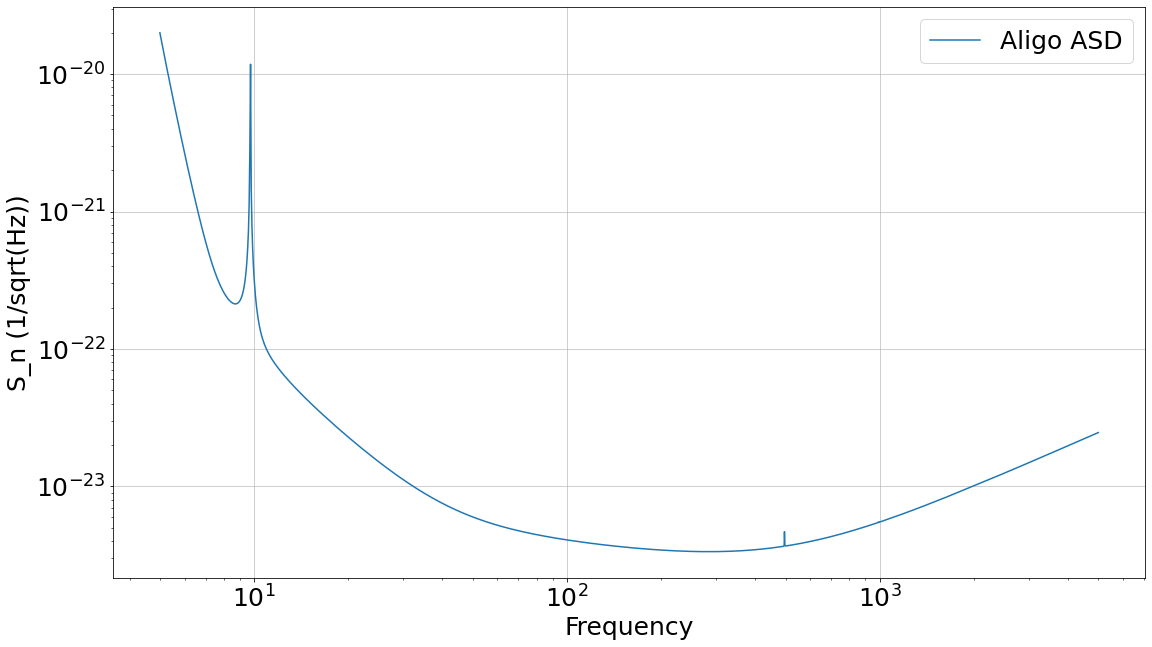

In [44]:
freq_for_plot_Aligo=np.linspace(Aligo_freq.min(),Aligo_freq.max(),100000)
plt.rcParams.update({'font.size': 25})
fig,ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Frequency')
ax.set_ylabel('S_n (1/sqrt(Hz))')

ax.plot(freq_for_plot_Aligo,Aligo_sn(freq_for_plot_Aligo),label='Aligo ASD')

plt.yscale('log')
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()

# Reading the Catalogue

In [26]:
#------------read the catalogue-------------------------------------
dat = Table.read('EVA03.fits', format='fits')
EVA = dat.to_pandas()#all good, is an only text fits
#print(EVA.columns)
ds_x=EVA['DS_x']
ds_y=EVA['DS_y']
ds_z=EVA['DS_z']
m1=EVA['M1']
m2=EVA['M2']
cos_inc=EVA['cos_orbital_incl']
inclin=np.arccos(cos_inc)
psi=EVA['psi']
zz=EVA['DS_redshift']

In [27]:
#----------Aproximant-------------------------------
#EVA['Aproximant']='IMRPhenomD'
#t = Table.from_pandas(EVA)
#t.write('EVA02.fits', overwrite=True)

In [28]:
theta=np.zeros(EVA.shape[0])
phi=np.zeros(EVA.shape[0])
com_distance=np.zeros(EVA.shape[0])
#SNR=np.zeros(EVA.shape[0])
for i in range(EVA.shape[0]):
    phi[i]=phi_from_cart(ds_x[i],ds_y[i])
    theta[i]=theta_from_cart(ds_x[i],ds_y[i],ds_z[i])
    com_distance[i]=np.sqrt(ds_x[i]**2+ds_y[i]**2+ds_z[i]**2)
cos_theta=np.cos(theta)

In [29]:
EVA.head()

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,SNR,Aproximant,merged
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,47.566179,b'IMRPhenomD',1
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,94.996610,b'IMRPhenomD',1
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,168.103360,b'IMRPhenomD',0
3,2566.548362,58.913997,1323.989640,0.801273,2571.261103,58.839892,1319.617234,0.802053,0.694977,14.085194,1.642785,0.116632,4.078907,70.825260,b'IMRPhenomD',0
4,1165.316454,2573.915761,575.600923,0.799466,1165.316454,2573.915761,575.600923,0.799466,-0.838562,5.332573,2.141039,0.401502,2.813217,89.006671,b'IMRPhenomD',1


In [30]:
print('I am doing the best I can, please wait...')
start_time = time.time()
with Pool(10) as p:
    #mysnr=p.map(Multi_SNR, range(EVA.shape[0]))
    mysnr=p.map(Multi_SNR, range(3))
print("--- %s seconds ---" % (time.time() - start_time))

I am doing the best I can, please wait...


/tmp/ipykernel_3712450/1304144830.py:50: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint,ET_min_freq,ET_max_freq,args=(hp))[0]
/tmp/ipykernel_3712450/1304144830.py:50: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on

--- 0.4156463146209717 seconds ---


In [31]:
#EVA['SNR']=mysnr
#EVA.drop('SNR', inplace=True, axis=1)
#EVA.insert(loc=14, column='SNR', value=mysnr)

In [25]:
mysnr

[96.27979809489385, 81.33620277750654, 114.00806941023359]

In [28]:
mysnr

[96.27979809489385]

In [18]:
print('I am doing the best I can, please wait...')
start_time = time.time()
with Pool(10) as p:
    tupla_SNR= p.map(network_angular_response, range(1))
print("--- %s seconds ---" % (time.time() - start_time))
total_SNR,hanford,livingstone,virgo,kagra=zip(*tupla_SNR)

I am doing the best I can, please wait...


/tmp/ipykernel_66027/2091876097.py:33: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
/tmp/ipykernel_66027/2091876097.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_cross=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hc_interpol))[0]


--- 0.4225330352783203 seconds ---


In [19]:
print(total_SNR,hanford,livingstone,virgo,kagra)

(5.348932638627237,) (3.6159051513005758,) (2.798500126828502,) (2.570359948505816,) (1.0478344738687186,)


In [ ]:
#t = Table.from_pandas(EVA)
#t.write('EVA02.fits', overwrite=True)

In [55]:
#dat = Table.read('EVA02.fits', format='fits')
#EVA= dat.to_pandas()#all good, is an only text fits

In [56]:
EVA.head()

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR
0,651.933995,402.188065,2806.954546,0.808803,651.933995,402.188065,2806.954546,0.808803,0.793474,10.569518,5.143687,0.486653,2.550917,b'IMRPhenomD',96.279798
1,1901.947841,477.181005,2147.676656,0.808301,1901.947841,477.181005,2147.676656,0.808301,-0.615400,26.536605,5.515256,0.207836,3.274064,b'IMRPhenomD',81.336203
2,792.327061,2056.292634,1873.462461,0.802654,796.891722,2051.491963,1868.765822,0.800800,0.228812,38.501322,29.412304,0.763930,3.479153,b'IMRPhenomD',114.008069
3,2566.548362,58.913997,1323.989640,0.801273,2571.261103,58.839892,1319.617234,0.802053,0.694977,14.085194,1.642785,0.116632,4.078907,b'IMRPhenomD',29.901415
4,1165.316454,2573.915761,575.600923,0.799466,1165.316454,2573.915761,575.600923,0.799466,-0.838562,5.332573,2.141039,0.401502,2.813217,b'IMRPhenomD',22.195059


In [88]:
primarymass=np.array(EVA['M1'])
secondarymass=np.array(EVA['M2'])
snr=np.array(EVA['SNR'])
lines=np.zeros(len(primarymass))
totalmass=30
error=0.25
for i in range(len(primarymass)):
    m1=primarymass[i]
    m2=secondarymass[i]
    if ((m1+m2>(totalmass-error)) and (m1+m2)<(totalmass+error)):
        lines[i]=1
        #print(m1+m2)
lines=lines.astype(int)

In [89]:
mydata=EVA
mydata['count']=lines
mydata=mydata[mydata['count']==1]


In [90]:
mydata.head(5)

,Host_x,Host_y,Host_z,Host_redshift,DS_x,DS_y,DS_z,DS_redshift,cos_orbital_incl,M1,M2,q,psi,Aproximant,SNR,count
243,444.830049,1350.013118,2550.359652,0.812431,442.253741,1352.200133,2543.993893,0.810659,-0.971494,25.654352,4.434806,0.172868,3.541943,b'IMRPhenomD',124.189958,1
260,167.022614,1384.495339,2558.114214,0.810213,167.022614,1384.495339,2558.114214,0.810213,-0.782124,26.999419,3.055616,0.113173,2.181048,b'IMRPhenomD',85.129980,1
329,257.350432,117.147793,2926.086061,0.819627,257.350432,117.147793,2926.086061,0.819627,0.064880,21.734982,8.027283,0.369326,0.179934,b'IMRPhenomD',66.749281,1
613,133.007961,166.948563,2931.568840,0.819487,130.616085,161.731242,2924.819848,0.816918,0.469192,25.797172,3.980470,0.154299,2.790796,b'IMRPhenomD',74.405718,1
1260,2725.284588,948.741583,247.493277,0.804046,2725.284588,948.741583,247.493277,0.804046,-0.763571,19.239518,10.828529,0.562827,5.107271,b'IMRPhenomD',59.503328,1


In [91]:
#------------read the catalogue-------------------------------------
ds_x=np.asarray(mydata['DS_x'])
ds_y=np.asarray(mydata['DS_y'])
ds_z=np.asarray(mydata['DS_z'])
m1=np.asarray(mydata['M1'])#5*np.ones(mydata.shape[0])#
m2=np.asarray(mydata['M2'])#5*np.ones(mydata.shape[0])#
cos_inc=np.asarray(mydata['cos_orbital_incl'])
inclin=np.arccos(cos_inc)
psi=np.asarray(mydata['psi'])
zz=np.asarray(mydata['DS_redshift'])

In [ ]:
theta=np.zeros(mydata.shape[0])
phi=np.zeros(mydata.shape[0])
com_distance=np.zeros(mydata.shape[0])
#SNR=np.zeros(EVA.shape[0])
for i in range(mydata.shape[0]):
    phi[i]=phi_from_cart(ds_x[i],ds_y[i])
    theta[i]=theta_from_cart(ds_x[i],ds_y[i],ds_z[i])
    com_distance[i]=np.sqrt(ds_x[i]**2+ds_y[i]**2+ds_z[i]**2)
cos_theta=np.random.uniform(-1,1,mydata.shape[0])#np.cos(theta)
phi=np.random.uniform(0,2*np.pi,mydata.shape[0])

In [92]:
#####---------to recreate efficency plot----------------####
Npoints=100000
ncopies=int(Npoints/len(m1))
newm1=m1
newm2=m2
lim=len(m1)-1
#print(ncopies)
newm1=np.zeros(Npoints)
newm2=np.zeros(Npoints)
for i in range(Npoints):
    index=np.random.randint(0,lim)
    newm1[i]=m1[index]
    newm2[i]=m2[index]
#for i in range(ncopies):
#    newm1=np.append(newm1,m1)
#    newm2=np.append(newm2,m2)
m1=newm1
m2=newm2
ndark=len(m1)
cos_inc=np.random.uniform(-1,1,ndark)
inclin=np.arccos(cos_inc)
psi=np.random.uniform(0,2*np.pi,ndark)

cos_theta=np.random.uniform(-1,1,ndark)#np.cos(theta)
theta=np.arccos(cos_theta)
phi=np.random.uniform(0,2*np.pi,ndark)
zz=np.linspace(0.001,2,ndark)
com_distance=cosmoeuclid.comoving_distance(zz).value

In [ ]:
print(len(m1))

In [93]:
#print('I am doing the best I can, please wait...')
#start_time = time.time()
#with Pool(40) as p:
#    allsnr=p.map(Multi_SNR_plus, range(ndark))
#print("--- %s seconds ---" % (time.time() - start_time))

print('I am doing the best I can, please wait...')
start_time = time.time()
with Pool(40) as p:
    mynewsnr=p.map(network_angular_response_plus, range(ndark))
print("--- %s seconds ---" % (time.time() - start_time))
allsnr,hanford,livingstone,virgo,kagra=zip(*mynewsnr)


I am doing the best I can, please wait...


<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The occurrence of roundoff error is detected, w

<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The occurrence of roundoff error is detected, w

<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the int

<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(signal_noise_toint_network,Aligo_min_freq,Aligo_max_freq,args=(hp_interpol))[0]
<ipython-input-54-379093bd8e66>:82: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the int

--- 813.5218999385834 seconds ---


In [94]:
allsnr=np.asarray(allsnr)
detected=allsnr[allsnr>=8]
print(len(allsnr),len(detected))
#detected=np.array(mydetected['count'])
#redtotal=np.array(mydata['DS_redshift'])
#reddetected=np.array(mydetected['DS_redshift'])

100000 11565


In [95]:
total=np.asarray(allsnr)
zipped=zip(total,zz)
zipped_total=list(zipped)
zipped_total=np.asarray(zipped_total)

In [96]:
steps=200
percentage=[]
midpoint=[]
error=[]
binsize=(zz.max()-zz.min())/steps
for i in range(steps):
    start=zz.min()+i*binsize
    stop=zz.min()+(i+1)*binsize
    midpoint.append(start+(stop-start)/2)
    
    temp_total=zipped_total[zipped_total[:,1]>=start]
    temp_total=temp_total[temp_total[:,1]<=stop]
    temp_total=np.delete(temp_total,1,1)
    temp_detected=temp_total[temp_total[:]>=8]
    
    percentage.append(len(temp_detected)/len(temp_total))
    error.append(1/np.sqrt(len(temp_detected)))
#percentage10=np.asarray(percentage)
#midpoint10=np.asarray(midpoint)
#error10=np.asarray(error)
#np.savetxt('ET_zz_midpoint.txt',midpoint10)
#np.savetxt('ET_10_eff.txt',percentage10)
#percentage20=np.asarray(percentage)
#midpoint20=np.asarray(midpoint)
#error20=np.asarray(error)
#np.savetxt('ET_20_eff.txt',percentage20)
#percentage30=np.asarray(percentage)
#midpoint30=np.asarray(midpoint)
#error30=np.asarray(error)
#np.savetxt('ET_30_eff.txt',percentage30)

#aligo_percentage10=np.asarray(percentage)
#aligo_midpoint10=np.asarray(midpoint)
#aligo_error10=np.asarray(error)
#np.savetxt('Aligo_zz_midpoint.txt',aligo_midpoint10)
#np.savetxt('Aligo_10_eff.txt',aligo_percentage10)
#aligo_percentage20=np.asarray(percentage)
#aligo_midpoint20=np.asarray(midpoint)
#aligo_error20=np.asarray(error)
#np.savetxt('Aligo_20_eff.txt',aligo_percentage20)
aligo_percentage30=np.asarray(percentage)
aligo_midpoint30=np.asarray(midpoint)
aligo_error30=np.asarray(error)
np.savetxt('Aligo_30_eff.txt',aligo_percentage30)

<ipython-input-96-0d9f2034f0f8>:17: RuntimeWarning: divide by zero encountered in double_scalars
  error.append(1/np.sqrt(len(temp_detected)))


In [181]:
midpoint=np.loadtxt('ET_zz_midpoint.txt')
aligo_midpoint=np.loadtxt('Aligo_zz_midpoint.txt')
percentage10=np.loadtxt('ET_10_eff.txt')
percentage20=np.loadtxt('ET_20_eff.txt')
percentage30=np.loadtxt('ET_30_eff.txt')
aligo_percentage10=np.loadtxt('Aligo_10_eff.txt')
aligo_percentage20=np.loadtxt('Aligo_20_eff.txt')
aligo_percentage30=np.loadtxt('Aligo_30_eff.txt')
addenda_zz_ET=np.array([midpoint[0]*0.1,midpoint[0]*0.2,midpoint[0]*0.3,
                        midpoint[0]*0.4,midpoint[0]*0.5,midpoint[0]*0.6,
                        midpoint[0]*0.7,midpoint[0]*0.8,midpoint[0]*0.9])
addenda_eff=np.ones(len(addenda_zz_ET))
percentage10=np.append(addenda_eff,percentage10)
percentage20=np.append(addenda_eff,percentage20)
percentage30=np.append(addenda_eff,percentage30)
midpoint=np.append(addenda_zz_ET,midpoint)

addenda_zz_aligo=np.array([aligo_midpoint[0]*0.1,aligo_midpoint[0]*0.2,aligo_midpoint[0]*0.3,
                        aligo_midpoint[0]*0.4,aligo_midpoint[0]*0.5,aligo_midpoint[0]*0.6,
                        aligo_midpoint[0]*0.7,aligo_midpoint[0]*0.8,aligo_midpoint[0]*0.9])
aligo_addenda_eff=np.ones(len(addenda_zz_aligo))
aligo_percentage10=np.append(aligo_addenda_eff,aligo_percentage10)
aligo_percentage20=np.append(aligo_addenda_eff,aligo_percentage20)
aligo_percentage30=np.append(aligo_addenda_eff,aligo_percentage30)
aligo_midpoint=np.append(addenda_zz_aligo,aligo_midpoint)


In [206]:
######Simoidal Fit
def rev_sigmoidal(x,k,x0,N):
    y=1-N/(1+np.exp(-k*(x-x0)))
    return y
#def rev_sigmoidal_30(x,k,x0,N):
#    y=(1-N/(1+np.exp(-k*(x-x0))))
#    return y

In [215]:
param,covariance=curve_fit(rev_sigmoidal,aligo_midpoint,aligo_percentage10)
fit_k=param[0]
fit_xo=param[1]
fit_N=param[2]
#fit_c=param[3]
aligo_fit_temp10=rev_sigmoidal(aligo_midpoint,fit_k,fit_xo,fit_N)
param,covariance=curve_fit(rev_sigmoidal,aligo_midpoint,aligo_percentage20)
fit_k=param[0]
fit_xo=param[1]
fit_N=param[2]
#fit_c=param[3]
aligo_fit_temp20=rev_sigmoidal(aligo_midpoint,fit_k,fit_xo,fit_N)
param,covariance=curve_fit(rev_sigmoidal,aligo_midpoint,aligo_percentage30)
fit_k=param[0]
fit_xo=param[1]
fit_N=param[2]
#fit_c=param[3]
aligo_fit_temp30=rev_sigmoidal(aligo_midpoint,fit_k,fit_xo,fit_N)

param,covariance=curve_fit(rev_sigmoidal,midpoint,percentage10)
fit_k=param[0]
fit_xo=param[1]
fit_N=param[2]
#fit_c=param[3]
print(fit_k,fit_xo,fit_N)
fit_temp10=rev_sigmoidal(midpoint,fit_k,fit_xo,fit_N)
param,covariance=curve_fit(rev_sigmoidal,midpoint,percentage20)
fit_k=param[0]
fit_xo=param[1]
fit_N=param[2]
#fit_c=param[3]
print(fit_k,fit_xo,fit_N)
fit_temp20=rev_sigmoidal(midpoint,fit_k,fit_xo,fit_N)
param,covariance=curve_fit(rev_sigmoidal,midpoint,percentage30,p0=[2,13,1])
fit_k=param[0]
fit_xo=param[1]
fit_N=param[2]
#fit_c=param[3]
fit_temp30=rev_sigmoidal(midpoint,fit_k,fit_xo,fit_N)

0.8364473754112357 3.4309595975053555 0.9924453625681443
0.3410493004452721 7.229198846826396 0.9780852948459837


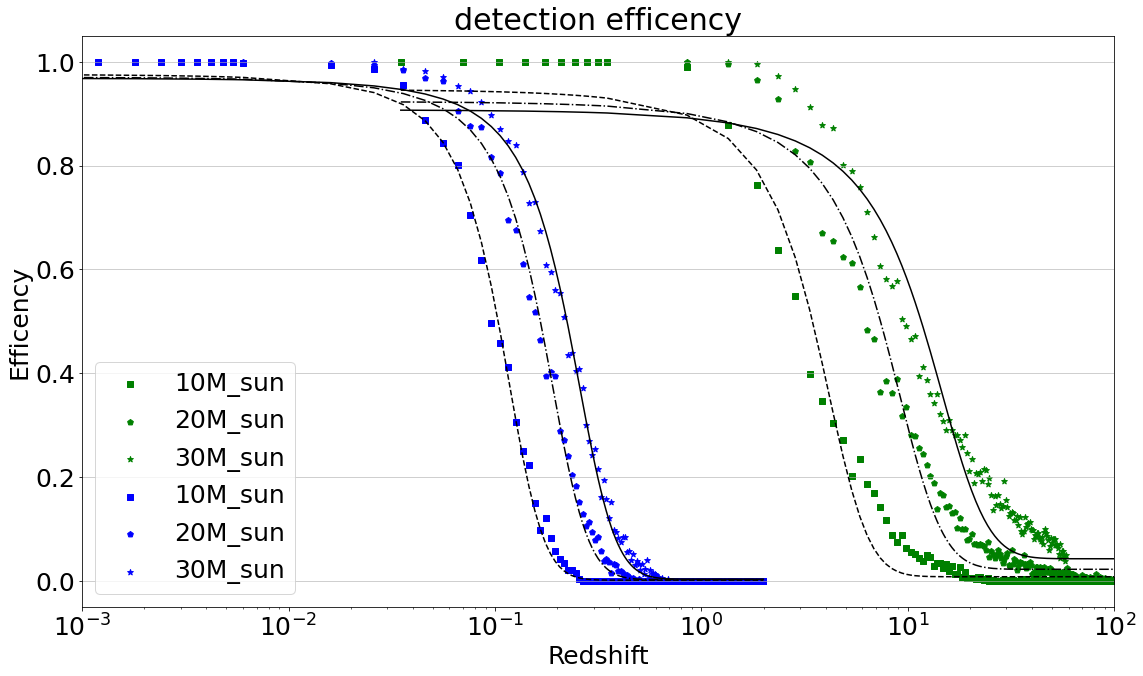

In [216]:
plt.rcParams.update({'font.size': 25})
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.scatter(midpoint,percentage10,label='10M_sun',color='g',marker='s')

ax.scatter(midpoint,percentage20,label='20M_sun',color='g',marker='p')

ax.scatter(midpoint,percentage30,label='30M_sun',color='g',marker='*')
ax.plot(midpoint,fit_temp30,color='k', ls='-')
ax.plot(midpoint,fit_temp20,color='k', ls='-.')
ax.plot(midpoint,fit_temp10,color='k', ls='--')

ax.scatter(aligo_midpoint,aligo_percentage10,label='10M_sun',color='b',marker='s')

ax.scatter(aligo_midpoint,aligo_percentage20,label='20M_sun',color='b',marker='p')

ax.scatter(aligo_midpoint,aligo_percentage30,label='30M_sun',color='b',marker='*')
ax.plot(aligo_midpoint,aligo_fit_temp30,color='k', ls='-')
ax.plot(aligo_midpoint,aligo_fit_temp20,color='k', ls='-.')
ax.plot(aligo_midpoint,aligo_fit_temp10,color='k', ls='--')

plt.grid(axis='y', alpha=0.75)
plt.legend()
ax.set_xlim([0.001,100])
#plt.grid(axis='x', alpha=0.75)
plt.xlabel('Redshift')
plt.ylabel('Efficency')
plt.title('detection efficency')
plt.xscale('log')
plt.savefig('efficency.png')

In [211]:
aligo_10=interpolate.interp1d(aligo_midpoint,aligo_fit_temp10,kind='cubic',fill_value="extrapolate")
aligo_20=interpolate.interp1d(aligo_midpoint,aligo_fit_temp20,kind='cubic',fill_value="extrapolate")
aligo_30=interpolate.interp1d(aligo_midpoint,aligo_fit_temp30,kind='cubic',fill_value="extrapolate")

In [179]:
look=zip(percentage30,midpoint)
look_total=list(look)
look_total=np.asarray(look_total)
eff=look_total[look_total[:,1]>=1.8]
eff=eff[eff[:,1]<=2.15]
#temp_total=np.delete(temp_total,1,1)
#temp_detected=temp_total[temp_total[:]>=8]
print(eff)
look=zip(percentage20,midpoint)
look_total=list(look)
look_total=np.asarray(look_total)
eff=look_total[look_total[:,1]>=1.8]
eff=eff[eff[:,1]<=2.15]
print(eff)
look=zip(percentage10,midpoint)
look_total=list(look)
look_total=np.asarray(look_total)
eff=look_total[look_total[:,1]>=1.8]
eff=eff[eff[:,1]<=2.15]
print(eff)

[[0.996   1.84825]]
[[0.964   1.84825]]
[[0.762   1.84825]]


In [ ]:
zref=0.001
m1=7
m2=7
zds=0.2
lum_dist=cosmo15.comoving_distance(zds).value*(1+zds)
disr_mart=4.451350096358855
fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1+m2)*astro_const.M_sun.value)
df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
#FDhp,FDhc = waveform.get_fd_waveform(approximant="IMRPhenomD",
#                           mass1=m1[i], mass2=m2[i],inclination=inclin[i],
#                           distance=lum_distance[i],
#                           spin1z=0,spin2z=0,  
#                           delta_f=1.0/500,f_lower=0.5,f_final=0)
FDhp,FDhc = waveform.get_fd_waveform(
                                     approximant="IMRPhenomD",
                                     mass1=m1, 
                                     mass2=m2,
                                     inclination=0,
                                     spin1z=0,
                                     spin2z=0,  
                                     distance=lum_dist,
                                     delta_f=df,
                                     f_lower=0.5,f_final=0
                                    )
freq=np.array(FDhp.sample_frequencies)
FDwfp = np.array(FDhp.data)[freq>=ET_min_freq]
FDwfc = np.array(FDhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]

In [ ]:
mart_freq=np.loadtxt('freqtest.txt')
mart_wave=np.loadtxt('waveform.txt').view(complex)

In [ ]:
falsecross=np.zeros(len(freq))
falsecross=falsecross.astype(int)
start_time = time.time()
hp_interpol=interpolate.interp1d(freq,abs(FDwfp*((1+zds)**2)),fill_value="extrapolate")
hc_interpol=interpolate.interp1d(freq,abs(falsecross),fill_value="extrapolate")
cos_theta=0
phi=0
psi=0
SNR=ET_SNR_Evaluation(cos_theta,phi,psi,hp_interpol,hc_interpol)
end_time= time.time()
print("--- %s seconds ---" % ((time.time() - start_time)))
print(SNR)

In [ ]:
 def snrfunc(zz, zz0, ff0, waveform0, lum_dist, det_noises):
        """
        This function returns the signal-to-noise ratio for an event.

        :param zz: the redshift of the event.
        :param zz0: a reference redshift.
        :param ff0: the frequency of the gravitational wave emitted by the merger.
        :param waveform0: the waveform (i.e. the GW strain) for the event.
        :param lum_dist: the luminosity distance to the event.
        :param source_extinctions: the source extinctions
        :param det_noises: the total power spectral density for the telescope.
        """
        #det_noises_sq_arr = np.array([det_noises[kk](ff) for kk in range(len(det_noises))])
        ff     = ff0#/(1+zz)
        ref_dL = disr_mart#cosmoglob.comoving_distance(zref).value*(1+zref)#lum_dist(zz0)
        new_dL = cosmoglob.comoving_distance(zz).value*(1+zz)#lum_dist(zz)
        #scaled_waveform = interpolate.interp1d(ff,waveform0*ref_dL/new_dL*(1+zz)**2,kind='cubic',bounds_error=False,fill_value=(0,0))
        scaled_waveform = interpolate.interp1d(ff,((1+zz)**2)*waveform0*ref_dL/new_dL,kind='cubic',bounds_error=False,fill_value=(0,0))
        integ = lambda x: 4*(np.square(np.real(scaled_waveform(x)))+np.square(np.imag(scaled_waveform(x))))/(3*det_noises(x)**2)
        #integ = lambda x: 4*(np.square(abs(scaled_waveform(x))))/(det_noises(x)**2)
        #snrsq_vec = []
        #for arm,noise in enumerate(det_noises):
        #    snrsq_vec.append(4 * np.trapz(self.snr_integrand(zz, zz0, ff0, waveform0, lum_dist, noise), ff))

        integrand = integ(ff)
        snr =  np.trapz(integrand, ff)
        #snr = quad(integ, min(ff), max(ff))[0]

        return snr#np.array(snrsq_vec)


In [ ]:
mart_SNR=np.sqrt(snrfunc(zds, zref, freq, mart_wave, disr_mart, ET_sn))

In [ ]:
print(mart_SNR)

In [ ]:
100*(abs(SNR-mart_SNR))/SNR

In [ ]:
m1=7
m2=7
lum_dist=cosmoglob.comoving_distance(zref).value*(1+zref)
disr_mart=4.451350096358855
fisco = constants.c**3/(constants.G*6**1.5*2*np.pi*(m1+m2)*astro_const.M_sun.value)
df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))
#FDhp,FDhc = waveform.get_fd_waveform(approximant="IMRPhenomD",
#                           mass1=m1[i], mass2=m2[i],inclination=inclin[i],
#                           distance=lum_distance[i],
#                           spin1z=0,spin2z=0,  
#                           delta_f=1.0/500,f_lower=0.5,f_final=0)
FDhp,FDhc = waveform.get_fd_waveform(
                                     approximant="IMRPhenomD",
                                     mass1=m1, 
                                     mass2=m2,
                                     inclination=0,
                                     spin1z=0,
                                     spin2z=0,  
                                     distance=1,
                                     delta_f=df,
                                     f_lower=0.5,f_final=0
                                    )
freq=np.array(FDhp.sample_frequencies)
FDwfp00 = np.array(FDhp.data)[freq>=ET_min_freq]
FDwfc00 = np.array(FDhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]

FDhp,FDhc = waveform.get_fd_waveform(
                                     approximant="IMRPhenomD",
                                     mass1=m1, 
                                     mass2=m2,
                                     inclination=0,
                                     spin1z=0,
                                     spin2z=0,  
                                     distance=100,
                                     delta_f=df,
                                     f_lower=0.5,f_final=0
                                    )
freq=np.array(FDhp.sample_frequencies)
FDwfp01 = np.array(FDhp.data)[freq>=ET_min_freq]
FDwfc01 = np.array(FDhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]

FDhp,FDhc = waveform.get_fd_waveform(
                                     approximant="IMRPhenomD",
                                     mass1=m1, 
                                     mass2=m2,
                                     inclination=0,
                                     spin1z=0,
                                     spin2z=0,  
                                     distance=200,
                                     delta_f=df,
                                     f_lower=0.5,f_final=0
                                    )
freq=np.array(FDhp.sample_frequencies)
FDwfp02 = np.array(FDhp.data)[freq>=ET_min_freq]
FDwfc02 = np.array(FDhc.data)[freq>=ET_min_freq]
freq=freq[freq>=ET_min_freq]


In [ ]:
hp00=interpolate.interp1d(freq,abs(FDwfp00),fill_value="extrapolate")
hp01=interpolate.interp1d(freq,abs(FDwfp01),fill_value="extrapolate")
hp02=interpolate.interp1d(freq,abs(FDwfp02),fill_value="extrapolate")
plt.rcParams.update({'font.size': 25})
fig,ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Frequency')
ax.set_ylabel('Rapporto')
ax.plot(freq,hp01(freq)/hp00(freq),label='h(100)/h(1)')
ax.plot(freq,hp02(freq)/hp00(freq),label='h(200)/h(1)')
#ax.plot(freq,hp02(freq)/hp01(freq),label='h(200)/h(100)')
#ax.plot(freq,hp(freq),label='hand made')
#ax.plot(freq,hp_abs(freq)**2,label='abs')

#plt.yscale('log')
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()

In [ ]:
np.sqrt(1-(0.6)**2)